In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats #conda install scikit-learn
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

train = pd.read_csv('bbva_train.csv')
test =  pd.read_csv('bbva_test_incomplete.csv')

In [2]:
train.head()

,ID_CORRELATIVO,CODMES,FLG_BANCARIZADO,RANG_INGRESO,FLAG_LIMA_PROVINCIA,EDAD,ANTIGUEDAD,ATTRITION,RANG_SDO_PASIVO_MENOS0,SDO_ACTIVO_MENOS0,...,NRO_ENTID_SSFF_MENOS2,NRO_ENTID_SSFF_MENOS3,NRO_ENTID_SSFF_MENOS4,NRO_ENTID_SSFF_MENOS5,FLG_SDO_OTSSFF_MENOS0,FLG_SDO_OTSSFF_MENOS1,FLG_SDO_OTSSFF_MENOS2,FLG_SDO_OTSSFF_MENOS3,FLG_SDO_OTSSFF_MENOS4,FLG_SDO_OTSSFF_MENOS5
0,53643,201208,1,Rang_ingreso_06,Lima,32.0,8.0,1,Cero,15940,...,3,3,3,3,1,1,1,1,1,1
1,67960,201208,1,Rang_ingreso_03,Lima,25.0,5.0,0,Rango_SDO_02,0,...,5,5,5,4,1,1,1,1,1,1
2,93652,201208,1,Rang_ingreso_02,Lima,35.0,0.0,0,Rango_SDO_01,0,...,1,1,1,1,1,1,1,1,1,1
3,52446,201208,1,Rang_ingreso_03,Lima,32.0,6.0,0,Cero,1670,...,3,3,3,3,1,1,1,1,1,1
4,96645,201208,1,Rang_ingreso_07,Lima,30.0,9.0,0,Rango_SDO_01,2620,...,4,3,3,3,1,1,1,1,1,1


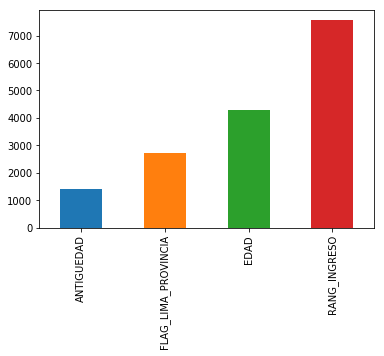

In [3]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

- La variable con el missing mas alto es RANG_INGRESO

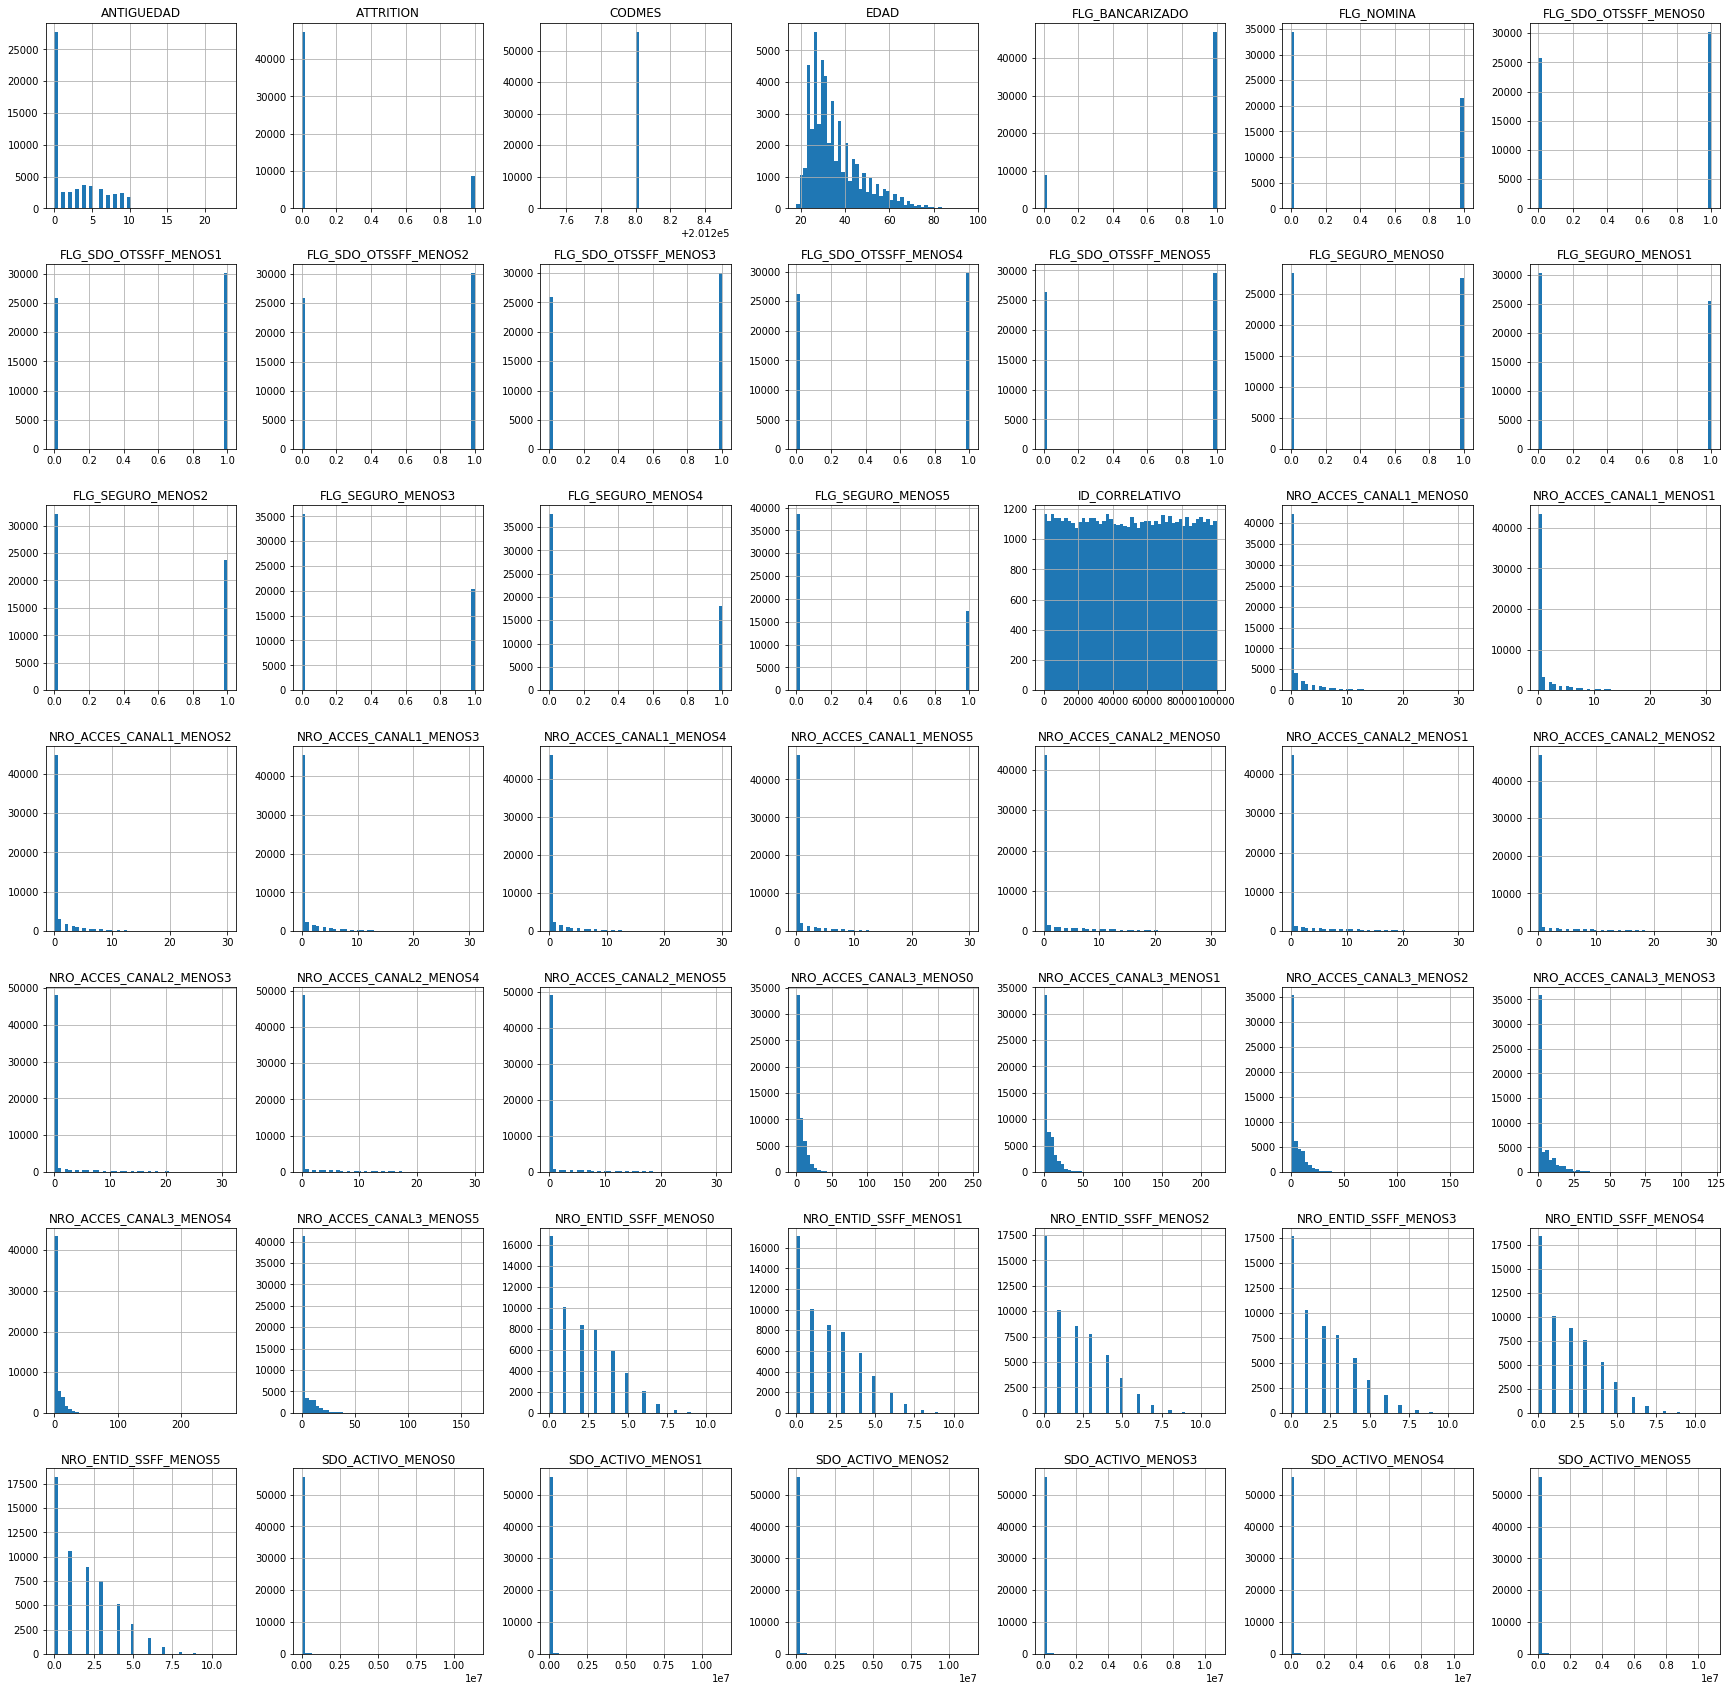

In [4]:
train.hist(bins=50, figsize=(30,30))
plt.show()

In [5]:
correlation = train.corr()
correlation["ATTRITION"].sort_values(ascending=False)

ATTRITION                  1.000000
EDAD                       0.004558
ID_CORRELATIVO             0.003097
SDO_ACTIVO_MENOS3         -0.029459
SDO_ACTIVO_MENOS2         -0.030188
SDO_ACTIVO_MENOS5         -0.030247
SDO_ACTIVO_MENOS1         -0.030803
SDO_ACTIVO_MENOS4         -0.030999
SDO_ACTIVO_MENOS0         -0.031104
NRO_ACCES_CANAL3_MENOS1   -0.031347
NRO_ACCES_CANAL3_MENOS0   -0.053116
FLG_BANCARIZADO           -0.054360
FLG_SDO_OTSSFF_MENOS5     -0.064415
FLG_NOMINA                -0.067474
FLG_SDO_OTSSFF_MENOS4     -0.071433
NRO_ACCES_CANAL3_MENOS2   -0.074465
NRO_ACCES_CANAL2_MENOS1   -0.075961
NRO_ACCES_CANAL2_MENOS0   -0.076798
FLG_SDO_OTSSFF_MENOS3     -0.078318
NRO_ACCES_CANAL2_MENOS5   -0.078530
NRO_ACCES_CANAL2_MENOS4   -0.078825
NRO_ACCES_CANAL2_MENOS2   -0.080535
NRO_ACCES_CANAL2_MENOS3   -0.081850
FLG_SDO_OTSSFF_MENOS2     -0.083846
FLG_SDO_OTSSFF_MENOS1     -0.085176
NRO_ENTID_SSFF_MENOS5     -0.085729
FLG_SDO_OTSSFF_MENOS0     -0.086107
NRO_ENTID_SSFF_MENOS4     -0

- Se observa que ATTRITION no presenta correlacion con casi ninguna variable, el mayor valor de correlacion lo tiene EDAD y es 0.004

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from scipy import sparse
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

- Ahora separaremos Xtrain y Ytrain de nuestro dataset train

In [3]:
Xtrain = train.drop("ATTRITION", axis=1)
Ytrain = train["ATTRITION"].copy()
print(train.shape)
print(Xtrain.shape)
print(Ytrain.shape)

(56000, 53)
(56000, 52)
(56000,)


- Ahora debemos convertir nuestras variables categóricas a numéricas para poder trabajar. Para ello usamos LabelEncoder de sklearn

In [4]:
for i in range(Xtrain.shape[1]):
    if Xtrain.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(Xtrain.iloc[:,i].values) )
        Xtrain.iloc[:,i] = lbl.transform(list(Xtrain.iloc[:,i].values))

In [9]:
Xtrain.head()

,ID_CORRELATIVO,CODMES,FLG_BANCARIZADO,RANG_INGRESO,FLAG_LIMA_PROVINCIA,EDAD,ANTIGUEDAD,RANG_SDO_PASIVO_MENOS0,SDO_ACTIVO_MENOS0,SDO_ACTIVO_MENOS1,...,NRO_ENTID_SSFF_MENOS2,NRO_ENTID_SSFF_MENOS3,NRO_ENTID_SSFF_MENOS4,NRO_ENTID_SSFF_MENOS5,FLG_SDO_OTSSFF_MENOS0,FLG_SDO_OTSSFF_MENOS1,FLG_SDO_OTSSFF_MENOS2,FLG_SDO_OTSSFF_MENOS3,FLG_SDO_OTSSFF_MENOS4,FLG_SDO_OTSSFF_MENOS5
0,53643,201208,1,5,0,32.0,8.0,0,15940,14530,...,3,3,3,3,1,1,1,1,1,1
1,67960,201208,1,2,0,25.0,5.0,2,0,0,...,5,5,5,4,1,1,1,1,1,1
2,93652,201208,1,1,0,35.0,0.0,1,0,0,...,1,1,1,1,1,1,1,1,1,1
3,52446,201208,1,2,0,32.0,6.0,0,1670,1460,...,3,3,3,3,1,1,1,1,1,1
4,96645,201208,1,6,0,30.0,9.0,1,2620,2560,...,4,3,3,3,1,1,1,1,1,1


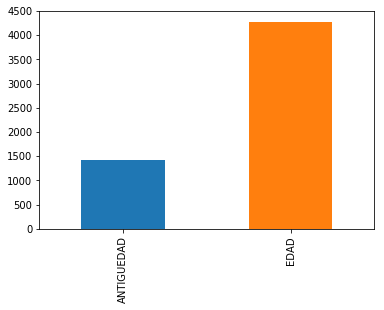

In [10]:
missingX = Xtrain.isnull().sum()
missingX = missingX[missingX > 0]
missingX.sort_values(inplace=True)
missingX.plot.bar()

- Observamos que FLAG_LIMA_PROVINCIA y RANG_INGRESO ya no contienen null pero ANTIGUEDAD y EDAD aún tienen null

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_attribs = list(Xtrain.select_dtypes(include=[np.number]))

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [7]:
Xtrain_final = num_pipeline.fit_transform(Xtrain)
Xtrain_final

array([[ 0.13025474,  0.        ,  0.43681264, ...,  0.9289127 ,
         0.93758654,  0.94426493],
       [ 0.6248649 ,  0.        ,  0.43681264, ...,  0.9289127 ,
         0.93758654,  0.94426493],
       [ 1.51244781,  0.        ,  0.43681264, ...,  0.9289127 ,
         0.93758654,  0.94426493],
       ...,
       [-0.83885921,  0.        ,  0.43681264, ..., -1.07652742,
         0.93758654,  0.94426493],
       [ 0.89457375,  0.        , -2.28931104, ..., -1.07652742,
        -1.06656821, -1.05902482],
       [ 0.81266269,  0.        ,  0.43681264, ...,  0.9289127 ,
        -1.06656821, -1.05902482]])

- Ahora nuestro dataset ya no contiene null, todos las variables son numéricas y están escaladas

In [8]:
def calcularPrecision(res, Y):
    contador = 0
    for i in range(res.shape[0]) :
        if ((res[i][0]) == Y[i]):
            contador +=1
    
    print((contador*100.0)/res.shape[0])

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

- Probaremos con RandomForestRegressor y LinearRegression

In [10]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(Xtrain_final, Ytrain.ravel())
BBVA_predictions = forest_reg.predict(Xtrain_final)


In [11]:
lin_reg = LinearRegression()
lin_reg.fit(Xtrain_final, Ytrain)
BBVA_predictions = lin_reg.predict(Xtrain_final)


- Elegimos RandomForestRegressor y lo tunearemos usando GridSearchCV y RandomizedSearchCV

In [12]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [13]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, Xtrain_final, Ytrain.ravel(),
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.33608035 0.32981597 0.33470936 0.3314228  0.33529039 0.3376653
 0.33044072 0.3341968  0.32746865 0.33312106]
Mean: 0.33302113945880724
Standard deviation: 0.003010569829871089


In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(Xtrain_final, Ytrain.ravel())
final_model = grid_search.best_estimator_
BBVA_predictions = final_model.predict(Xtrain_final)
final_mse = mean_squared_error(Ytrain, BBVA_predictions)
final_rmse = np.sqrt(final_mse)
print("El error (RMSE) del modelo final es: ",final_rmse)

El error (RMSE) del modelo final es:  0.12367688637017923


In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=50),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train1, Y_train1.ravel())
final_model = rnd_search.best_estimator_
BBVA_predictions = final_model.predict(X_test1)

NameError: name 'X_train1' is not defined

- Escogemos el tuneo hecho por RandomizedSearchCV

In [16]:
mat_cross = np.zeros((2,2))
prediccion = np.zeros((len(BBVA_predictions),1))

for i in range(0,len(BBVA_predictions)):
    if BBVA_predictions[i] >0.5:
        prediccion[i][0] = 1
            
for i in range(0,len(prediccion)):
    _j = int(Ytrain[i]) #valor real
    _i = int(prediccion[i][0]) #valor predicho
    mat_cross[_i][_j] += 1
    
print(mat_cross)

[[4.7339e+04 1.3000e+02]
 [3.0000e+00 8.5280e+03]]


In [17]:
BBVA_predictions

array([0.63333333, 0.        , 0.06666667, ..., 0.06666667, 0.        ,
       0.16666667])

#### Matriz y precisión del modelo final

In [59]:
mat_cross = np.zeros((2,2))
prediccion = np.zeros((len(BBVA_predictions),1))

for i in range(0,len(BBVA_predictions)):
    if BBVA_predictions[i] >0.5:
        prediccion[i][0] = 1
            
for i in range(0,len(prediccion)):
    _j = int(Ytrain[i]) #valor real
    _i = int(prediccion[i][0]) #valor predicho
    mat_cross[_i][_j] += 1
    
print(mat_cross)

[[4.7339e+04 1.3000e+02]
 [3.0000e+00 8.5280e+03]]


In [48]:
calcularPrecision(prediccion, Y_test1)

87.08791208791209


- Ahora prepararemos nuestro dataset de prueba para obtener las predicciones finales

In [23]:
test.head()

,ID_CORRELATIVO,CODMES,FLG_BANCARIZADO,RANG_INGRESO,FLAG_LIMA_PROVINCIA,EDAD,ANTIGUEDAD,RANG_SDO_PASIVO_MENOS0,SDO_ACTIVO_MENOS0,SDO_ACTIVO_MENOS1,...,NRO_ENTID_SSFF_MENOS2,NRO_ENTID_SSFF_MENOS3,NRO_ENTID_SSFF_MENOS4,NRO_ENTID_SSFF_MENOS5,FLG_SDO_OTSSFF_MENOS0,FLG_SDO_OTSSFF_MENOS1,FLG_SDO_OTSSFF_MENOS2,FLG_SDO_OTSSFF_MENOS3,FLG_SDO_OTSSFF_MENOS4,FLG_SDO_OTSSFF_MENOS5
0,12174,201208,1,Rang_ingreso_01,Provincia,62.0,0.0,Cero,2580,2760,...,4,4,3,3,1,1,1,1,1,1
1,49090,201208,1,Rang_ingreso_05,Lima,33.0,0.0,Rango_SDO_01,0,0,...,0,0,0,0,0,0,0,0,0,0
2,60617,201208,0,NaN,Lima,NaN,0.0,Rango_SDO_02,0,0,...,0,0,0,0,0,0,0,0,0,0
3,24584,201208,1,Rang_ingreso_04,Provincia,28.0,NaN,Rango_SDO_01,0,2010,...,3,4,3,3,1,0,0,1,1,1
4,70300,201208,1,Rang_ingreso_01,Provincia,31.0,0.0,Rango_SDO_01,0,0,...,1,1,1,1,0,0,0,0,0,0


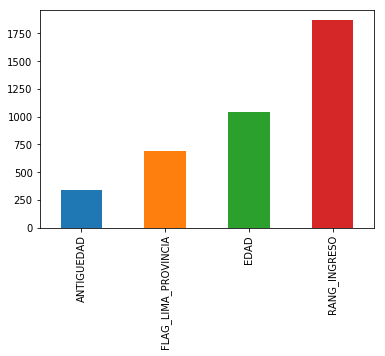

In [24]:
missingt = test.isnull().sum()
missingt = missingt[missingt > 0]
missingt.sort_values(inplace=True)
missingt.plot.bar()

In [18]:
from sklearn.pipeline import FeatureUnion

for i in range(test.shape[1]):
    if test.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(test.iloc[:,i].values) )
        test.iloc[:,i] = lbl.transform(list(test.iloc[:,i].values))

num_attribs = list(test.select_dtypes(include=[np.number]))
        
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

test_final = num_pipeline.fit_transform(test)
test_final

array([[-1.32252252,  0.        ,  0.44268259, ...,  0.94196664,
         0.9520074 ,  0.95337158],
       [-0.03600456,  0.        ,  0.44268259, ..., -1.06160872,
        -1.05041201, -1.04890897],
       [ 0.36570994,  0.        , -2.25895486, ..., -1.06160872,
        -1.05041201, -1.04890897],
       ...,
       [-0.98343324,  0.        ,  0.44268259, ...,  0.94196664,
         0.9520074 ,  0.95337158],
       [ 0.4329702 ,  0.        ,  0.44268259, ..., -1.06160872,
        -1.05041201, -1.04890897],
       [ 1.16892984,  0.        ,  0.44268259, ..., -1.06160872,
        -1.05041201, -1.04890897]])

- Predicciones finales

In [19]:
BBVA_test_predictions = final_model.predict(test_final)
BBVA_test_predictions

array([0.06666667, 0.3       , 0.03333333, ..., 0.46666667, 0.06666667,
       0.03333333])

In [25]:
prediccion_final = []

for i in range(0,1400):
    if BBVA_test_predictions[i] >0.5:
        prediccion_final.append(1)
    else:
        prediccion_final.append(0)
prediccion_final

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [26]:
def sigmoid(z):
    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 / (1 + np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [27]:
def initialize_parameters(n_x, n_h, n_y):
    
    np.random.seed(2) # Recordemos que los pesos /tetha/W se inicializan en random
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    W2 = np.random.randn(n_y, n_h ) * 0.01
    #W1 = theta_1
    #W2 = theta_2


    #assert (W1.shape == (n_h, n_x))
    #assert (W2.shape == (n_y, n_h ))
    
    parameters = {"W1": W1,                  
                  "W2": W2}
    return parameters

In [28]:
def forward(X,parameters):
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    m = X.shape[0]
    A1 = np.c_[np.ones((m,1)),X] #Añadimos el bías (5000,401)
    Z2 = np.dot(A1, W1.T)#(5000,401) * (401,25) = (5000,25)
    A2 = sigmoid(Z2)# (5000,25)
    #A2 = np.c_[np.ones((Z2.shape[0],1)),A2] #Añadiendo una columna (5000,26)
    Z3 = np.dot(A2,W2.T) #(5000,26) * (26,10) = 5000,10)
    A3 = sigmoid(Z3)#(5000,10) --nuestra predicción
    
    cache = {"A1": A1,
             "Z2": Z2,
             "A2": A2,
             "Z3": Z3,
             "A3": A3}
    
    return A3,cache

In [29]:
def compute_cost(A3, Y):
    m = Y.shape[0] #(5000,10)
    cost = (- 1 / m) * np.sum(np.sum(Y * np.log(A3) + (1 - Y) * (np.log(1 - A3)), axis=1), axis=0)
    return cost


In [30]:
def sigmoidGradient(z):
    gz = sigmoid(z)
    return gz * (1-gz);

In [31]:
def compute_gradient_reg(cache,parameters, X, yNew):
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    a1 = cache["A1"] #(5000,401)
    z2 = cache["Z2"] #(5000,21)
    a2 = cache["A2"] #(5000,26)
    z3 = cache["Z3"] #(5000,10)
    a3 = cache["A3"] #(5000,10)
    
    m = X.shape[0]
    
    d3 = a3 - yNew #(5000,10)
    #d2 = np.dot(d3,W2) * sigmoidGradient(np.c_[np.ones((z2.shape[0],1)),z2])#sigmoide again
    d2 = np.dot(d3,W2) * sigmoidGradient(z2)#sigmoide again
    #print("d2: ", d2[0][0])
    #d2 = d2[:,1:]  #(5000,25)
    
    delta1 = np.dot(d2.T,a1) #(25,5000).(5000,401) = (25,401)
    delta2 = np.dot(d3.T,a2) #(10,5000).(5000,26) = (10,26)
    
    grad1 = delta1/m
    grad2 = delta2/m
    
    grad = {"grad1": grad1,
            "grad2": grad2,
           }
    
    return grad

In [32]:
def update_parameters(parameters, grads, learning_rate=1.8):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
   
    dW1 = grads["grad1"]
    dW2 = grads["grad2"]


    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [33]:
def nn_model(X, Y, n_h, num_iterations=4000):

    np.random.seed(3)
    n_x = X.shape[1]+1
    n_y = Y.shape[1] 
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A3, cache = forward(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A3, Y)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = compute_gradient_reg(cache, parameters, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        """"print("grad1: ", grads["grad1"][0][0])
        print("grad2: ", grads["grad2"][0][0])
        print("W1: ", parameters["W1"][0][0])
        print("W2: ", parameters["W2"][0][0])"""
        ### END CODE HERE ###
        
        # Print the cost every 1000 iterations
        if i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))

    return parameters

In [34]:
Ynew = np.zeros((Ytrain.shape[0], 1))
for i in range(0,Ytrain.shape[0]):
    Ynew[i][0] = Ytrain[i]

In [35]:
from sklearn.model_selection import train_test_split
import random
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(Xtrain_final, Ynew, test_size=0.13, random_state=random.randrange(50))

In [36]:
pesos = nn_model(X_train1, Y_train1, 27)

Cost after iteration 0: 0.693219
Cost after iteration 100: 0.390599
Cost after iteration 200: 0.378727
Cost after iteration 300: 0.374467
Cost after iteration 400: 0.372960
Cost after iteration 500: 0.371631
Cost after iteration 600: 0.370024
Cost after iteration 700: 0.368123
Cost after iteration 800: 0.366047
Cost after iteration 900: 0.363941
Cost after iteration 1000: 0.361948
Cost after iteration 1100: 0.360204
Cost after iteration 1200: 0.358702
Cost after iteration 1300: 0.357392
Cost after iteration 1400: 0.356218
Cost after iteration 1500: 0.355129
Cost after iteration 1600: 0.354069
Cost after iteration 1700: 0.353033
Cost after iteration 1800: 0.352015
Cost after iteration 1900: 0.351007
Cost after iteration 2000: 0.350006
Cost after iteration 2100: 0.349007
Cost after iteration 2200: 0.347997
Cost after iteration 2300: 0.346961
Cost after iteration 2400: 0.345882
Cost after iteration 2500: 0.344743
Cost after iteration 2600: 0.343533
Cost after iteration 2700: 0.342270
Cost

In [40]:
BBVA_NN_predictions, cache = forward(Xtrain_final,pesos)

In [41]:
BBVA_NN_predictions1, cache = forward(X_test1,pesos)

In [37]:
BBVA_test_predictions = forward(test_final,pesos)

In [62]:
BBVA_NN_predictions

array([[0.07839435],
       [0.12125826],
       [0.25435256],
       ...,
       [0.35440166],
       [0.02428318],
       [0.06358127]])

In [41]:
NN_mse = mean_squared_error(Ytrain, BBVA_NN_predictions)
NN_rmse = np.sqrt(NN_mse)
print("El error (RMSE) de la NN es: ",NN_rmse)

El error (RMSE) de la NN es:  0.31928024213859946


In [42]:
mat_cross = np.zeros((2,2))
prediccion = np.zeros((len(BBVA_NN_predictions),1))

for i in range(0,len(BBVA_NN_predictions)):
    if BBVA_NN_predictions[i][0] >0.5:
        prediccion[i][0] = 1
            
for i in range(0,len(prediccion)):
    _j = int(Ytrain[i]) #valor real
    _i = int(prediccion[i][0]) #valor predicho
    mat_cross[_i][_j] += 1
    
print(mat_cross)

[[46710.  7140.]
 [  632.  1518.]]


In [43]:
mat_cross = np.zeros((2,2))
prediccion = np.zeros((len(BBVA_NN_predictions1),1))

for i in range(0,len(BBVA_NN_predictions1)):
    if BBVA_NN_predictions1[i][0] >0.5:
        prediccion[i][0] = 1
            
for i in range(0,len(prediccion)):
    _j = int(Y_test1[i]) #valor real
    _i = int(prediccion[i][0]) #valor predicho
    mat_cross[_i][_j] += 1
    
print(mat_cross)

NameError: name 'BBVA_NN_predictions1' is not defined

In [56]:
calcularPrecision(prediccion, Ytrain)

86.12142857142857


In [43]:
calcularPrecision(prediccion,Y_test1)

86.11263736263736


In [57]:
test_ids = test["ID_CORRELATIVO"].copy()

In [63]:
submission = pd.DataFrame({
    "ATTRITION": prediccion_final,
    "ID_CORRELATIVO": test_ids
})

submission = submission[['ID_CORRELATIVO', 'ATTRITION']]
submission

,ID_CORRELATIVO,ATTRITION
0,12174,0
1,49090,0
2,60617,0
3,24584,0
4,70300,1
5,42687,0
6,57527,0
7,70786,0
8,60622,0
9,9447,0


In [67]:
BBVA_NN_predictions,cache = forward(test_final,pesos)
BBVA_NN_predictions.shape
ANN_prediccion_final = []
for i in range(0,1400):
    if BBVA_NN_predictions[i][0] > 0.5:
        ANN_prediccion_final.append(1)
    else:
        ANN_prediccion_final.append(0)
print("done...")


done...


In [68]:

si = 0
no = 0
for i in range (0,1400):
    if(BBVA_NN_predictions[i] == prediccion_final[i]):
        si += 1
    else:
        no += 1
print("si: ",si)
print("no: ",no)

si:  0
no:  1400
